# Portfolio Optimization

This notebook compares the results of several different optimization schemes.

In [1]:
import os
from itertools import chain
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pandas as pd

import yabte.utilities.pandas_extension
from yabte.backtest import (
    Book,
    OrderSizeType,
    PositionalBasketOrder,
    Strategy,
    StrategyRunner,
)
from yabte.utilities.portopt.hierarchical_risk_parity import hrp
from yabte.utilities.portopt.inverse_volatility import inverse_volatility
from yabte.utilities.portopt.minimum_variance import minimum_variance

In [2]:
# load sample nasdaq data
from yabte.tests._helpers import generate_nasdaq_dataset

assets, df_combined = generate_nasdaq_dataset()

In [3]:
# run strategy for each portfolio optimization scheme


class PortfolioOptimizationStrat(Strategy):
    def init(self):
        data = self.data
        self.symbols = data.columns.levels[0].tolist()
        p = self.params

        # determine weekday holidays
        hols_wd = pd.date_range(data.index[0], data.index[-1], freq="B").difference(
            data.index
        )
        bday_freq = pd.tseries.offsets.CustomBusinessDay(holidays=hols_wd)

        # determine calibration days
        data.loc[:, ("_META", "CalibrationDate")] = data.index.isin(
            pd.date_range(
                sr.data.index[0], sr.data.index[-1], freq=p.calibration_frequency
            )
        )

    def on_close(self):
        # warm up - allow approx 1y to pass
        if (self.ts - self.data.index[0]).days < 252:
            return

        p = self.params

        # do calibration if we fall on correct date
        cd = self.data["_META"].CalibrationDate.iloc[-1]
        p["weights"] = None
        if cd:
            closes = self.data.loc[:, (slice(None), "Close")].droplevel(axis=1, level=1)
            returns = closes.prc.log_returns
            Sigma = returns.cov()
            R = returns.corr()
            sigma = returns.std()
            mu = closes.prc.capm_returns()

            match p.weight_scheme:
                case "HRP":
                    w = hrp(R, sigma)
                case "GMVP":
                    w = minimum_variance(Sigma, mu, p.target_return)
                    assert np.isclose(w @ mu, p.target_return)
                case "IVP":
                    w = inverse_volatility(Sigma)
                case _:
                    raise AttributeError("Unknown weight scheme")

            assert np.isclose(w.sum(), 1)
            p["weights"] = (100 * w).tolist()

        if p["weights"] is not None:
            self.orders.append(
                PositionalBasketOrder(
                    asset_names=self.symbols,
                    weights=p.weights,
                    size=1,
                    size_type=OrderSizeType.BOOK_PERCENT,
                )
            )


book = Book(name="Main", cash="100000")
sr = StrategyRunner(
    data=df_combined,
    assets=assets,
    strategies=[PortfolioOptimizationStrat()],
    books=[book],
)

srrs = []
schemes = ["HRP", "GMVP", "IVP"]
for scheme in schemes:
    srrs.append(
        sr.run(
            {
                "target_return": 0.01,  # only used for GMVP
                "weight_scheme": scheme,
                "calibration_frequency": "W-MON",
            }
        )
    )

<Axes: title={'center': 'Total Book Value'}>

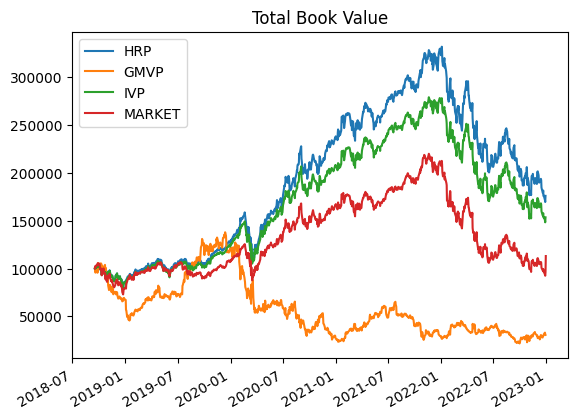

In [4]:
# compare results against market

df = pd.DataFrame(
    {scheme: srrs[ix].book_history.Main.total for ix, scheme in enumerate(schemes)}
)
first_date = df[df == 100000].last_valid_index()
market = 100000 * pd.concat(
    [
        pd.Series({first_date: 1}),
        (
            [1]
            + df_combined.loc[:, (slice(None), "Close")]
            .mean(axis=1)
            .to_frame()
            .prc.log_returns.loc[first_date:, :]
            .iloc[1:, :]
        ).cumprod(),
    ]
)
market.columns = ["MARKET"]
pd.concat([df.loc[first_date:, :], market], axis=1).plot(title="Total Book Value")

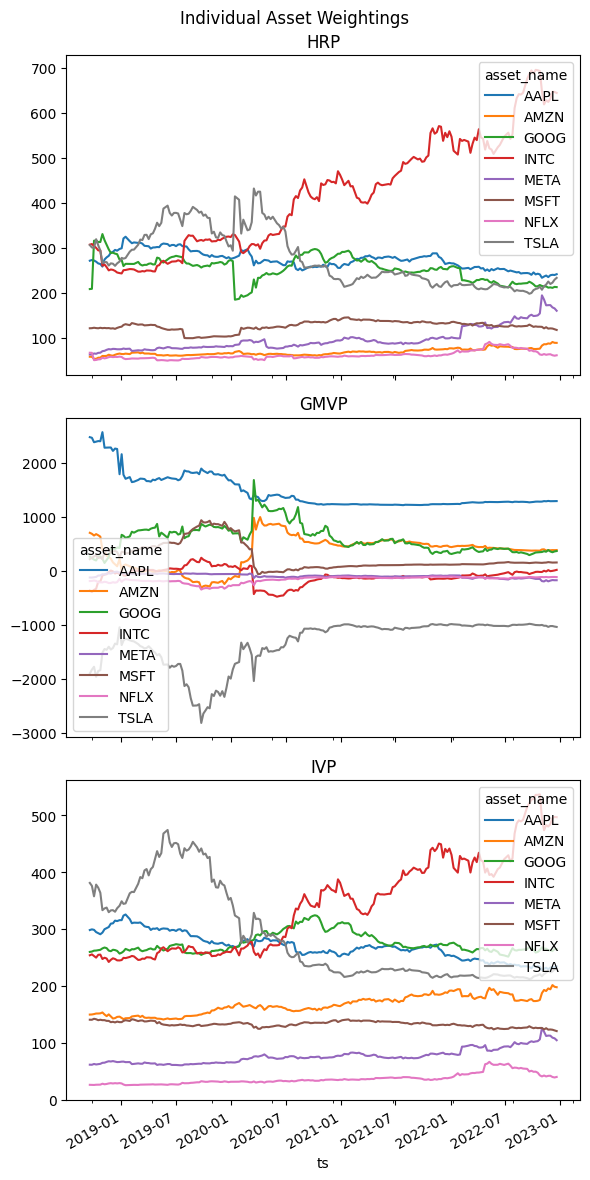

In [5]:
# plot the weightings for each scheme
fig, axs = plt.subplots(3, 1, figsize=(1 * 6, 3 * 4), sharex=True)
fig.suptitle("Individual Asset Weightings")
for ix, scheme in enumerate(schemes):
    srrs[ix].transaction_history.pivot_table(
        index="ts", values="quantity", columns="asset_name"
    ).cumsum().plot(ax=axs[ix], title=scheme)
fig.tight_layout()